In [5]:
# import torch
# DEVICE  = torch.device('cuda:0')

In [1]:
!git clone https://github.com/mastryukov1990/mok_mas_gan2.git
!ls /content/mok_mas_gan2/*.py

Cloning into 'mok_mas_gan2'...
remote: Enumerating objects: 1249, done.
remote: Counting objects: 100% (1249/1249), done.
remote: Compressing objects: 100% (1124/1124), done.
remote: Total 1249 (delta 136), reused 1226 (delta 113), pack-reused 0
Receiving objects: 100% (1249/1249), 4.38 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/mok_mas_gan2/main.py


In [2]:
from PIL import Image
from mok_mas_gan2.RaGAN.conf import IMSIZE, DEVICE
from torchvision import transforms
from mok_mas_gan2.RaGAN.utils import imshow
# from mok_mas_gan2.RaGAN.Testutils import wimg
img = Image.open('/content/mok_mas_gan2/RaGAN/256_256.jpg')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IMSIZE,IMSIZE)),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])
img = transform(img)
img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

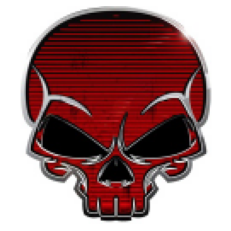

In [3]:
imshow(img)

In [4]:
import torch
wimg = torch.stack([img.view(3,IMSIZE,IMSIZE) ,img.view(3,IMSIZE,IMSIZE)]).to(DEVICE)


In [5]:
from mok_mas_gan2.RaGAN.Conv2dBlock import Conv2dBlock
from mok_mas_gan2.RaGAN.JsonDataLoader import JsonDataLoader


gen = JsonDataLoader('/content/mok_mas_gan2/RaGAN/generator.json')
gen_params = gen.get_data()

dis = JsonDataLoader('/content/mok_mas_gan2/RaGAN/discriminator.json')
dis_params = dis.get_data()


In [11]:

from mok_mas_gan2.RaGAN.Generator import Generator
from mok_mas_gan2.RaGAN.Discriminator import Discriminator


D = Discriminator(dis_params)
G = Generator(gen_params)

D = disc.to(DEVICE)
G = gen.to(DEVICE)

In [12]:
# from mok_mas_gan2.RaGAN.FinalLoss import FinalLoss
from mok_mas_gan2.RaGAN.Loss import MeanLoss
from mok_mas_gan2.RaGAN.AL import AdversialLoss
from mok_mas_gan2.RaGAN.FML import FML
from mok_mas_gan2.RaGAN.SGRL import SGRL
from mok_mas_gan2.RaGAN.GL import GeometricLoss
from torchvision.models import vgg19




ml = MeanLoss() 
ml(wimg, wimg)             #usual mean eror: GT, fake ,for G

labels = torch.Tensor([1,1]).to(DEVICE)# labels fake or not
al = AdversialLoss()
al(wimg,labels, disc) # adversial error: fake, labels, disc for disc

fml = FML()
fml(wimg,wimg, disc.local_branch.to(DEVICE))#feature matching error: GT, fake , local branch for G 
fml(wimg,wimg, vgg19(True).features[:5].to(DEVICE)) # GT, fake , vgg feature matching for G

sgrl = SGRL()
sgrl(wimg,wimg)#self guid regression loss : GT, fake  for G

gl  = GeometricLoss()
gl(wimg,wimg) #geom align loss : GT, fake 

torch.Size([2, 1024])
torch.Size([2, 1024])


tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [13]:
def train_epoch(G, D, ground_truth, mask):

  valid = mask*ground_truth
  fake = G(valid)

  true_label = torch.ones(ground_truth.shape[0],1)
  fake_label= true_label*0


  G_loss = ml(fake,ground_truth ) \
      + fml(ground_truth, fake, vgg19(True).features[:5].to(DEVICE)) \
      + sgrl(ground_truth, fake)  + gl(fake, ground_truth )
  
  D_fake_label=  D(fake)
  D_true_label = D(ground_truth)

  D_loss = al(torch.cat([ground_truth, fake], 0),
              torch.cat([true_label, fake_label]).view(-1), D) + fml(wimg,wimg, disc.local_branch.to(DEVICE))
  


  loss = G_loss + D_loss
  loss.backward()
  # print(G_loss)
  return loss, G_loss, D_loss

In [15]:
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import CyclicLR

G_opt = SGD(G.parameters(),lr=0.001, momentum=0.9)
D_opt  = SGD(D.parameters(),lr=0.001, momentum=0.9) 

G_sched = CyclicLR(G_opt , 0.001,0.01)
D_sched = CyclicLR(D_opt , 0.001,0.01)


valid = torch.normal(0,0.3,[2,3,128,128]).to(DEVICE )

for i in range(1000):
  train_epoch(G, D, torch.cat([wimg,wimg],0 ), 
              torch.normal(0,0.2,[3,128,128]).to(DEVICE) )
  G_opt.step()
  D_opt.step()
  G_sched.step()
  D_sched.step()

torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])
torch.Size([4, 1024])


KeyboardInterrupt: ignored